# Coursera Capstone Project
This notebook will be used for the Coursera Capstone project.

In [13]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [14]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


#### Connect to Foursquare

In [15]:
CLIENT_ID = 'O5RSPN0JJN4LB2FT0TZSQMEPOPXI24TN5CF1AMRV4BB1WS4A' # your Foursquare ID
CLIENT_SECRET = '55VJW152MHDGHPZDFWDADIXMJHCA4XRMIXB4CIPHFHTHEVOV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O5RSPN0JJN4LB2FT0TZSQMEPOPXI24TN5CF1AMRV4BB1WS4A
CLIENT_SECRET:55VJW152MHDGHPZDFWDADIXMJHCA4XRMIXB4CIPHFHTHEVOV


#### Let's create a function to get all venues nearby a location

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Preprocessing functions

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def preprocess(venues):
    # one hot encoding
    onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot['Neighbourhood'] = venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    
    # Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
    grouped = onehot.groupby('Neighbourhood').mean().reset_index()
    
    # Now let's create the new dataframe and display the top 10 venues for each neighborhood.
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighbourhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

    for ind in np.arange(grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted, grouped

# Toronto

### Parse Wikipedia page and preprocess
* Filter not assigned boroughs
* Set unassigned neighourhoods to name of borough
* Join rows with duplicate boroughs to single row with concatenated neighbourhoods

In [18]:
df_toronto = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df_toronto = df_toronto[0]
df_toronto = df_toronto[df_toronto["Borough"] != "Not assigned"]
df_toronto.loc[df_toronto["Neighbourhood"] == "Not assigned", "Neighbourhood"] = df_toronto["Borough"]
df_toronto = df_toronto.groupby(["Postcode", "Borough"])["Neighbourhood"].apply(', '.join).reset_index()
df_toronto

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [19]:
print("Number of rows of dataframe: %d" % df_toronto.shape[0])

Number of rows of dataframe: 103


In [20]:
geo = pd.read_csv("Geospatial_Coordinates.csv")
geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [21]:
df_toronto = df_toronto.join(geo.set_index("Postal Code"), on="Postcode")
df_toronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Get location of Toronto

In [22]:
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#address = 'Toronto'

#geolocator = Nominatim(user_agent="ny_explorer")
#location = geolocator.geocode(address)
#latitude_toronto = location.latitude
#longitude_toronto = location.longitude

latitude_toronto = 43.653963
longitude_toronto = -79.387207

print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


Let's visualize the neighborhoods of Toronto

In [23]:
# create map of Toronto using latitude and longitude values
map = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

#### Get Venues in Toronto

In [24]:
venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

#### Let's check the size of the resulting dataframe

In [25]:
print(venues.shape)
venues.head()

(2244, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


#### Let's check how many venues were returned for each neighborhood

In [26]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,57,57,57,57,57,57


#### Let's find out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 274 uniques categories.


# Analyze each neighborhood

In [112]:
neighborhoods_venues_sorted, grouped = preprocess(venues)

In [113]:
neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Gym,Bakery,Bar,Burger Joint
1,Agincourt,Breakfast Spot,Lounge,Sandwich Place,Skating Rink,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Beer Store,Pizza Place,Dumpling Restaurant,Drugstore
4,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Coffee Shop,Gym,Pharmacy,Athletics & Sports,Skating Rink,Sandwich Place,Department Store
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Sandwich Place,Supermarket,Middle Eastern Restaurant,Restaurant,Deli / Bodega,Bank,Fried Chicken Joint,Frozen Yogurt Shop,Fast Food Restaurant
6,Bayview Village,Bank,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
7,"Bedford Park, Lawrence Manor East",Fast Food Restaurant,Coffee Shop,Italian Restaurant,Greek Restaurant,Thai Restaurant,Liquor Store,Sandwich Place,Juice Bar,Butcher,Restaurant
8,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Steakhouse,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Farmers Market,Café
9,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


In [114]:
grouped.set_index("Neighbourhood")
grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.

# Wellbeing - Safety

In [31]:
safety_train = pd.read_excel("http://opendata.toronto.ca/social.development/wellbeing/WB-Safety.xlsx", 1, 1)
safety_train.set_index("Neighbourhood")
safety_test = pd.read_excel("http://opendata.toronto.ca/social.development/wellbeing/WB-Safety.xlsx", 2, 1)
safety_test.set_index("Neighbourhood")

,Neighbourhood Id,Arsons,Assaults,Break & Enters,Drug Arrests,Fire Medical Calls,Fire Vehicle Incidents,Fires & Fire Alarms,Hazardous Incidents,Murders,Robberies,Sexual Assaults,Thefts,Total Major Crime Incidents,Vehicle Thefts
Neighbourhood,,,,,,,,,,,,,,,
West Humber-Clairville,1,4,390,175,62,1321,502,705,210,0,82,68,54,1119,288
Mount Olive-Silverstone-Jamestown,2,3,316,61,90,1016,59,361,176,1,78,75,7,690,62
Thistletown-Beaumond Heights,3,0,85,36,16,323,48,90,34,0,17,24,2,192,12
Rexdale-Kipling,4,0,59,32,15,305,34,94,55,1,16,20,3,164,18
Elms-Old Rexdale,5,1,77,25,14,321,71,107,43,0,23,5,19,185,22
Kingsview Village-The Westway,6,0,134,59,47,680,186,244,117,1,32,22,8,351,48
Willowridge-Martingrove-Richview,7,2,131,66,18,640,78,228,111,0,48,22,8,342,49
Humber Heights-Westmount,8,1,41,28,12,512,37,165,64,0,15,1,1,106,8
Edenbridge-Humber Valley,9,1,57,75,4,317,25,113,73,0,18,5,5,185,21


### Join venue and safety data

In [59]:
joined_train = safety_train.join(grouped, how="inner", lsuffix="_0")
del joined_train["Neighbourhood_0"]
joined_train.set_index("Neighbourhood")
joined_test = safety_test.join(grouped, how="inner", lsuffix="_0")
del joined_test["Neighbourhood_0"]
joined_test.set_index("Neighbourhood")
joined_test.head()

,Neighbourhood Id,Arsons,Assaults,Break & Enters,Drug Arrests,Fire Medical Calls,Fire Vehicle Incidents,Fires & Fire Alarms,Hazardous Incidents,Murders,Robberies,Sexual Assaults,Thefts,Total Major Crime Incidents,Vehicle Thefts,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Sto

### Correlations

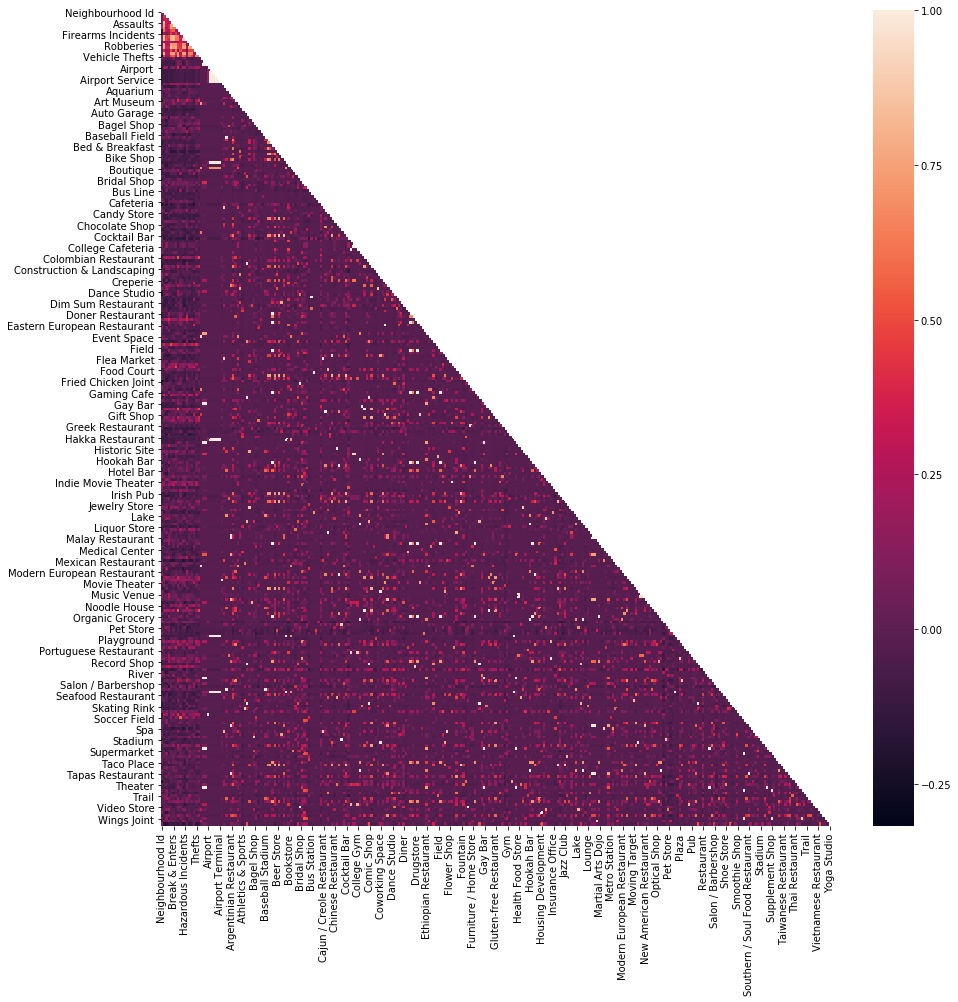

In [60]:
corr = joined_train.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr, mask=mask)

In [61]:
corr.head()

,Neighbourhood Id,Ambulance Calls,Ambulance Referrals,Arsons,Assaults,Break & Enters,Drug Arrests,Fire Vehicle Incidents,Firearms Incidents,Fires & Fire Alarms,Hazardous Incidents,Murders,Robberies,Sexual Assaults,TCHC Safety Incidents,Thefts,Vehicle Thefts,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thri

In [116]:
corr.iloc[safety_train.shape[1]+2, 1:safety_train.shape[1]].sort_values(ascending=False)[:5]

Fire Vehicle Incidents    0.401650
Fires & Fire Alarms       0.271274
Thefts                    0.255725
Vehicle Thefts            0.245793
Ambulance Calls           0.205429
Name: Airport, dtype: float64

Airports and fire, fire alarms and fire vehicle incidents are correlated.

In [117]:
corr.iloc[safety_train.shape[1]+8, 1:safety_train.shape[1]].sort_values(ascending=False)[:5]

Vehicle Thefts            0.327264
Murders                   0.265912
Drug Arrests              0.240028
Fire Vehicle Incidents    0.233083
Assaults                  0.224617
Name: American Restaurant, dtype: float64

American restaurants and Vehicle Thefts, Murders, Drug arrests and assaults are correlated (as well as BBQ joints, bagel shops, bars)

In [122]:
corr.iloc[safety_train.shape[1]+14, 1:safety_train.shape[1]].sort_values(ascending=False)[:3]

Fire Vehicle Incidents    0.396565
Vehicle Thefts            0.394308
Murders                   0.348079
Name: Art Museum, dtype: float64

Strangely, art museums and murders are correlated.

In [134]:
corr.iloc[safety_train.shape[1]+73, 1:safety_train.shape[1]].sort_values(ascending=False)[:3]

Vehicle Thefts            0.382650
Fire Vehicle Incidents    0.353905
Ambulance Referrals       0.178992
Name: Concert Hall, dtype: float64

During concerts, vehicles get stolen. 

In [144]:
corr.iloc[safety_train.shape[1]+92, 1:safety_train.shape[1]].sort_values(ascending=False)[:9]

Arsons                 0.401736
Murders                0.381824
Ambulance Referrals    0.307636
Sexual Assaults        0.305026
Firearms Incidents     0.264646
Hazardous Incidents    0.252290
Fires & Fire Alarms    0.216097
Drug Arrests           0.188385
Break & Enters         0.184199
Name: Drugstore, dtype: float64

Drug stores seem to be dangerous places.

In [147]:
corr.iloc[safety_train.shape[1]+101, 1:safety_train.shape[1]].sort_values(ascending=False)[:13]

Assaults                  0.513790
Thefts                    0.407563
Hazardous Incidents       0.375351
Ambulance Calls           0.374421
Sexual Assaults           0.368571
Drug Arrests              0.321326
Break & Enters            0.282744
TCHC Safety Incidents     0.228861
Fires & Fire Alarms       0.224875
Fire Vehicle Incidents    0.195933
Robberies                 0.169660
Arsons                    0.146332
Ambulance Referrals       0.145746
Name: Fast Food Restaurant, dtype: float64

Fast food restaurants seem to be the most dangerous places.

In [156]:
corr.iloc[safety_train.shape[1]+109, 1:safety_train.shape[1]].sort_values(ascending=False)[:1]

Drug Arrests    0.48263
Name: Food & Drink Shop, dtype: float64

Many drug arrests seem to happen in front of food shops.

In [160]:
corr.iloc[safety_train.shape[1]+119, 1:safety_train.shape[1]].sort_values(ascending=False)[:4]

Ambulance Calls    0.388750
Thefts             0.331781
Robberies          0.323973
Assaults           0.314579
Name: Garden, dtype: float64

Why are gardens correlated with ambulance calls??

In [185]:
corr.iloc[safety_train.shape[1]+196, 1:safety_train.shape[1]].sort_values(ascending=False)[:8]

Fire Vehicle Incidents    0.532798
Vehicle Thefts            0.498478
Ambulance Referrals       0.273625
Thefts                    0.252017
Break & Enters            0.245656
Robberies                 0.202323
Fires & Fire Alarms       0.197003
Arsons                    0.190851
Name: Opera House, dtype: float64

Opera houses are highly correlated with vehicle thefts and fire vehicle indicents...

# Modeling

In [82]:
from sklearn.linear_model import LinearRegression, Ridge
X_train = joined_train.iloc[:,safety_train.shape[1]:]
X_test = joined_test.iloc[:,safety_test.shape[1]:]
X_test

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

2008 and 2011 data have different columns, so we select a subgroup of columns.

In [83]:
crime = ["Arsons", "Assaults", "Break & Enters", "Drug Arrests", "Murders", "Robberies", "Sexual Assaults", "Thefts", "Vehicle Thefts"]
y_train = joined_train.loc[:, crime].sum(axis=1)
y_test = joined_test.loc[:, crime].sum(axis=1)
y_test.head()

0    1123
1     693
2     192
3     164
4     186
dtype: int64

In [84]:
reg = Ridge().fit(X_train, y_train)
reg.score(X_train, y_train)

0.3298020255156692

In [85]:
reg.coef_

array([-1.63269254e+00, -1.72733792e+00, -1.72733792e+00,  7.52082948e+01,
       -1.57273478e+01, -1.57273478e+01, -3.14546956e+01, -4.71820433e+01,
       -3.14546956e+01,  2.57564336e+02, -1.46373596e+01,  5.84484856e-01,
       -2.24981766e+01, -5.68093175e-01, -3.63463119e-01,  5.17291277e+00,
        1.45900496e+01, -3.27364771e+01, -9.23393114e+01, -2.70543657e+01,
       -1.44476984e+01,  1.19644483e+01,  6.75482183e+00,  1.35957254e+01,
       -6.33708189e+01,  1.03701118e+02,  7.90741346e+01, -1.05829316e+02,
        2.33793942e-01, -3.25888266e+00, -2.97526103e+00,  5.06253718e-01,
       -9.74779972e+00, -9.75809957e+01, -2.32381868e+00, -9.15207444e+00,
       -3.28126860e+00, -1.57273478e+01, -6.45555933e+00, -1.76798860e+01,
        1.59335221e+01,  4.48667983e+00, -2.43324721e+01, -3.93356000e+00,
        5.55533210e+00,  2.70593080e+01, -7.96934528e+00, -4.62362908e+01,
       -3.92843349e+01, -3.14843179e+01, -3.15170462e+01,  2.01448976e+01,
       -6.95855895e+01, -

In [86]:
pred = reg.predict(X_test)

In [87]:
reg.score(X_test, y_test)

0.35572204559335285

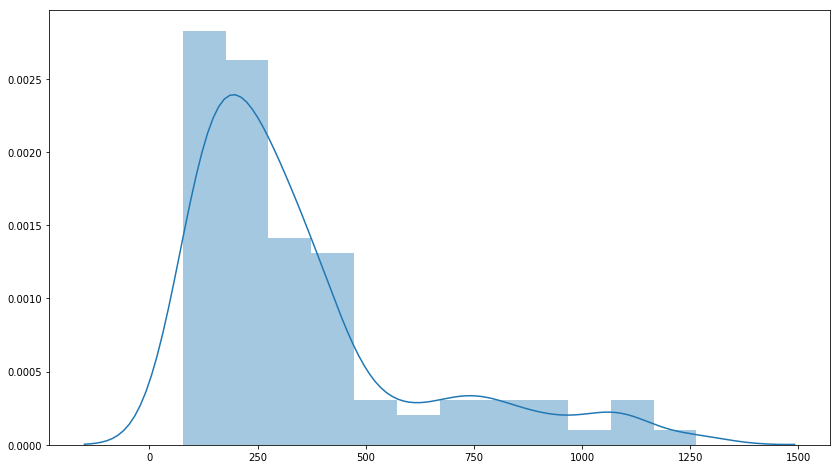

In [88]:
f, ax = plt.subplots(figsize=(14, 8))
sns.distplot(y_train)

In [89]:
_, bins = pd.cut(y_train.append(y_test), 2, retbins = True)

In [90]:
y_train_cat = pd.cut(y_train, bins)
bins

array([  75.678,  738.   , 1399.   ])

In [91]:
from sklearn.preprocessing import LabelEncoder
y_train_cat = LabelEncoder().fit_transform(y_train_cat)  


In [92]:
y_train_cat

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [93]:
y_test_cat = pd.cut(y_test, bins)
y_test_cat = LabelEncoder().fit_transform(y_test_cat)  

In [94]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train_cat)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
from sklearn.metrics import balanced_accuracy_score
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test_cat, y_pred)

0.6944444444444444